Reinforcement learning agent in the Cart Pole environment
===

Environment description
---

Actions: 
 - ndarray (1,)
 - {0, 1}: In which direction (0 = left, 1 = right) to push the cart.

Observation: 
 - ndarray (4,)
 - \[cart position, cart velocity, pole angle, pole angular velocity\]
 
Reward: 
 - float
 - Reward is for every step taken, including the termination step. Each step provides +1 reward.
 
Termination and truncation: 
 - bool
 - Pole Angle is more than ±12°
 - Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)
 - Episode length is greater than 500

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt

# Disable plot axes and ticks:
# plt.rcParams.update({
#     'axes.spines.top': False, 
#     'axes.spines.right': False, 
#     'axes.spines.bottom': False, 
#     'axes.spines.left': False, 
#     'xtick.bottom': False, 
#     'xtick.labelbottom': False, 
#     'ytick.labelleft': False, 
#     'ytick.left': False
# })
# plt.rcParams.update(plt.rcParamsDefault)

Environment

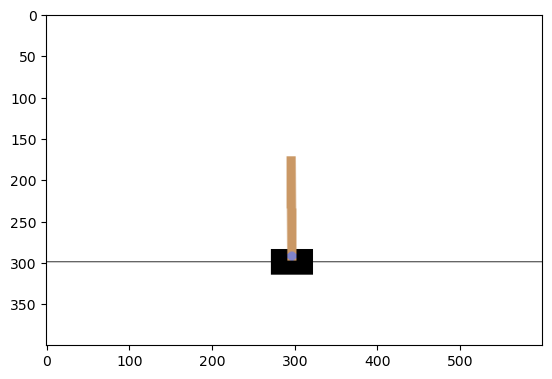

In [2]:
environment = gym.make('CartPole-v1', render_mode="rgb_array")

_ = environment.reset()
_ = plt.imshow(environment.render())

Agent

In [3]:
import torch
import torch.nn as nn

class Agent(nn.Module):
    def __init__(self):
        """Simple Agent for reinforcement learning with two hidden layers."""
        super(Agent, self).__init__()
        
        self.layer_in = nn.Linear(4, 512)
        self.layer_hidden_1 = nn.Linear(512, 256)
        self.layer_hidden_2 = nn.Linear(256, 128)
        self.layer_out = nn.Linear(128, 2)
        
    def forward(self, x):
        """
        Forward pass.
        
        Parameters
        ----------
        x : numpy.ndarray or torch.Tensor
            Observation state.
            
        Returns
        -------
        output : torch.Tensor
            Action probabilities.
        """
        _output = torch.relu(self.layer_in(x))
        _output = torch.relu(self.layer_hidden_1(_output))
        _output = torch.relu(self.layer_hidden_2(_output))
        output = self.layer_out(_output)
        
        return output

Training

In [4]:
import numpy as np

EPISODES = 1000
STEPS = 1000

GAMMA = 0.99            # Discount factor
epsilon = 1.0           # Exploration factor
epsilon_decay = 0.95

agent = Agent()

print(f"Trainable parameters: {sum(p.numel() 
                                   for p in agent.parameters() 
                                   if p.requires_grad)} \n\n")

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(agent.parameters(), 
                                lr=0.00025, alpha=0.95, eps=0.01)

metrics = {"lengths": np.zeros(EPISODES), "losses": np.zeros(EPISODES), 
           "reward": np.zeros(EPISODES), "epsilon": np.zeros(EPISODES)}

for episode in range(EPISODES):

    _lengths = []
    _losses = []
    _rewards = []
    
    observation, _ = environment.reset()
    observation = torch.tensor(observation, dtype=torch.float32)
    
    step = 0
    for _ in range(STEPS):
        step += 1
        
        actions = agent(observation)
        action = np.random.choice([0, 1]) \
            if np.random.rand() < epsilon \
            else actions.argmax().item()
        
        observation, reward, terminated, truncated, _ = environment.step(action)
        observation = torch.tensor(observation, dtype=torch.float32)
        
        # Compute the expected future reward. GitHub Copilot Chat suggested this.
        expected_reward = reward + GAMMA * agent(observation).max()
        expected_reward = torch.full_like(actions, expected_reward.item())
        _rewards.append(reward)
                
        # Compute the loss. Dividing by step to incentivice longer episodes.
        loss = loss_function(actions, expected_reward) * (10 / step)
        _losses.append(loss.item())
        
        # Weight updates with backpropagation.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if terminated or truncated:
            
            observation, _ = environment.reset()
            observation = torch.tensor(observation, dtype=torch.float32)
            
            _lengths.append(step)

            step = 0
    
    epsilon = (epsilon * epsilon_decay) if epsilon > 0.001 else 0.001
    
    metrics["lengths"][episode] = np.mean(_lengths)
    metrics["losses"][episode] = np.mean(_losses)
    metrics["reward"][episode] = np.mean(_rewards)
    metrics["epsilon"][episode] = epsilon
    
    if episode % 25 == 0 or episode == EPISODES-1:
        print(f"Episode {episode:<7} "
              f"Average time-steps: {int(metrics["lengths"][episode])} \n {'':>29}"
              f"loss: {metrics["losses"][episode]:>6.3f}")

Trainable parameters: 167042 

Episode 0       Average time-steps: 24 
                              loss:  2.118
Episode 25      Average time-steps: 34 
                              loss:  1.591
Episode 50      Average time-steps: 35 
                              loss:  1.571
Episode 75      Average time-steps: 44 
                              loss:  1.168
Episode 100     Average time-steps: 40 
                              loss:  1.337
Episode 125     Average time-steps: 30 
                              loss:  1.747
Episode 150     Average time-steps: 29 
                              loss:  1.804
Episode 175     Average time-steps: 25 
                              loss:  1.964
Episode 200     Average time-steps: 27 
                              loss:  1.921
Episode 225     Average time-steps: 29 
                              loss:  1.801
Episode 250     Average time-steps: 24 
                              loss:  2.058
Episode 275     Average time-steps: 26 
                

IndexError: index 1000 is out of bounds for axis 0 with size 1000

Visualize training

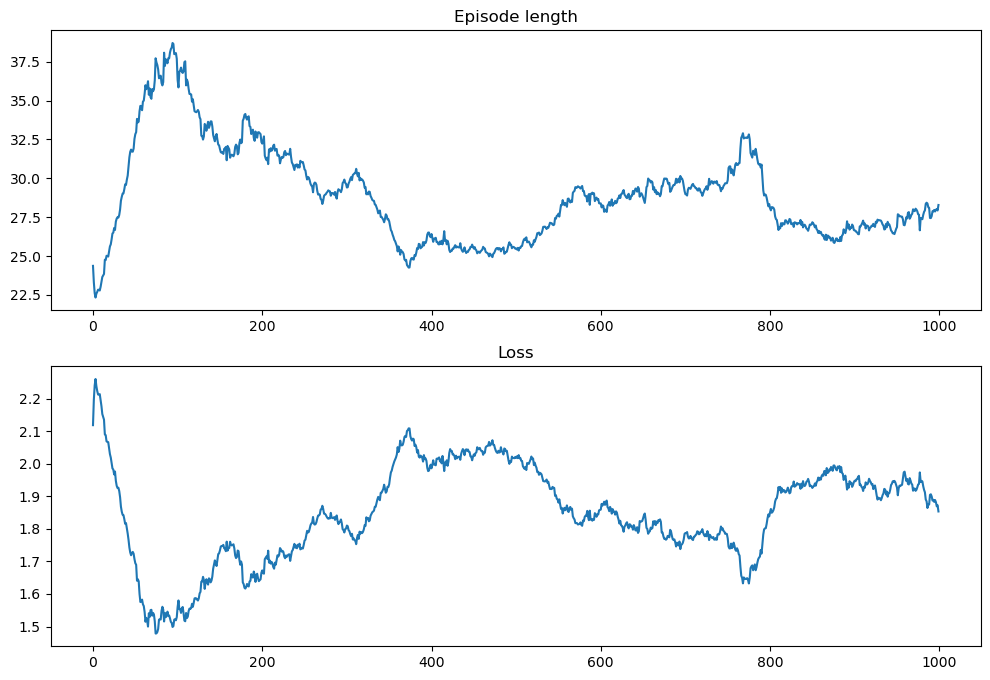

In [5]:
def moving_average(data, window_size=25):
    """Compute moving average of a list."""
    return [np.mean(data[max(0, i-window_size):(i+1)]) 
            for i in range(len(data))]

lengths_smooth = moving_average(metrics["lengths"])
losses_smooth = moving_average(metrics["losses"])

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].plot(lengths_smooth)
ax[0].set_title("Episode length")
ax[1].plot(losses_smooth)
ax[1].set_title("Loss")

plt.show()

In [6]:
environment.close()

Hyperparameters and agent architecture based on https://medium.com/analytics-vidhya/solving-open-ais-cartpole-using-reinforcement-learning-part-2-73848cbda4f1 